### Data Downloading
For our tutorial, we will be utilizing the Cornell Movie-Dialogs Corpus, a vast collection of over 220,000 conversational exchanges between more than 10,000 pairs of characters in various movies and TV shows.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")

print("Path to dataset files:", path)

Path to dataset files: /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1


In [3]:
!ls -r /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1

raw_script_urls.txt           movie_characters_metadata.txt
movie_titles_metadata.txt     chameleons.pdf
movie_lines.txt               README.txt
movie_conversations.txt


In [4]:
!mkdir datasets
!mv /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1/movie_conversations.txt ./datasets
!mv /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1/movie_lines.txt ./datasets

#### To begin our implementation of BERT, we first import the necessary libraries and preprocess the dataset by storing it into memory.

1. The data corpus is divided into two files, ‘movie_conversations.txt’ and ‘movie_lines.txt’.
2. We then split the text in ‘movie_lines.txt’ using a special delimiter (‘+++ $ +++’) to separate the line’s ID, character ID, movie ID, and dialogue text, and store them in a dictionary called line_dic.
3. Next, we generate question-answer pairs by iterating over each conversation in ‘movie_conversations.txt’ and pairing the current line’s text with the next line’s text for each conversation.
4. Finally, we limit the maximum length of the input sequence to 64 tokens, which is a common length used in many NLP tasks, by splitting the text and taking only the first 64 tokens.


In [5]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []
        
        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()  
        second = lines_dic[ids[i+1]].strip() 

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

In [6]:
print(pairs[21])

["She's not a...", "Lesbian? No. I found a picture of Jared Leto in one of her drawers, so I'm pretty sure she's not harboring same-sex tendencies."]


## WordPiece Tokenization
The initial stage of creating a fresh BERT model involves training a new tokenizer. Tokenization is the process of breaking down a text into smaller units called “tokens,” which are then converted into a numerical representation. An example of this would be splitting the sentence

 “I like surfboarding!” → [‘[CLS]’, ‘i’, ‘like’, ‘surf’, ‘##board’, ‘##ing’, ‘!’, ‘[SEP]’] → [1, 48, 250, 4033, 3588, 154, 5, 2]

A tokenized BERT input always starts with a special [CLS] token and ends with a special [SEP] token, which are used for specific purposes that will be explained later. BERT employs a WordPiece tokenizer, which can split a single word into multiple tokens. For instance, in the example given earlier, the word “surfboarding” is broken down into ['surf', '##boarding', '##ing']. This technique helps the model to understand that words like surfboardand snowboardhave shared meaning through the common wordpiece ##board. By referring to the explanation from HuggingFace, WordPiece computes a score for each pair, using the following

score = (freq_of_pair) / (freq_of_first_element × freq_of_second_element)

By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary. For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

To train the tokenizer, the BertWordPieceTokenizer from the transformer library was used with the steps below:

1. Saving the conversation text into multiple .txt files (with batch of N=10000)
2. Define BertWordPieceTokenizer with some parameters likeclean_text to remove control characters, handle_chinese_chars to include spaces around Chinese characters, stripe_accents to remove accents and
3. make é → e, ô → o, andlowercase to view capital and lowercase characters as equal.
4. Train the tokenizer based on the file path to .txt files with parameters like vocab_size defines the total number of tokens, min_frequency for minimum frequency for a pair of tokens to be merged, 
5. 5special_tokens defines a list of the special tokens that BERT uses, limit_alphabet for a maximum number of different characters, workpieces_prefix the prefix added to pieces of words (like ##ing).

In [7]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train( 
    files=paths,
    vocab_size=30_000, 
    min_frequency=5,
    limit_alphabet=1000, 
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

100%|██████████| 221616/221616 [00:00<00:00, 3288363.06it/s]


/Users/jainendra/miniconda3/envs/genai/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1947: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


**To specifically highlight these special tokens for BERT:**

* CLS stands for classification. It serves as the the Start of Sentence (SOS) and represent the meaning of the entire sentence.
SEP serves as End of Sentence (EOS) and also the separation token between first and second sentences.
* PADto be added into sentences so that all of them would be in equal length. During the training process, please note that the [PAD] token with id of 0 will not contribute to the gradient .
* MASK for word replacement during masked language prediction
* UNK serves as a replacement for token if it’s not being found in the tokenizer’s vocab.

**Pre-Training Strategy (Pre-processing)**
The unique pre-training strategy of BERT are the one of the many reasons for BERT to account for a sentence’s context. BERT does not try to predict the next word in the sentence but instead makes use of the following two strategies:

**1.Masked Language Model (MLM)**
The simple idea by masking 15% of the words with MASK token and predict them. Yet, there is a problem with this masking approach as the model only tries to predict when the [MASK] token is present in the input, while we want the model to try to predict the correct tokens regardless of what token is present in the input. To deal with this issue, out of the 15% of the tokens selected for masking:
- 80% of the tokens are actually replaced with the token [MASK].
- 10% of the time tokens are replaced with a random token.
- 10% of the time tokens are left unchanged.

**2.Next Sentence Prediction (NSP)**
The NSP task forces the model to understand the relationship between two sentences. In this task, BERT is required to predict whether the second sentence is related to the first one. During training, the model is fed with 50% of connected sentences and another half with random sentence sequence.


In [8]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

The code above defines a custom PyTorch Dataset class named BERTDataset, which is intended to be used for training a Bidirectional Encoder Representations from Transformers (BERT) model. The random_word method of the BERTDataset class performs the random replacement of tokens in each sentence using the given tokenizer object. The get_sent method returns a random sentence pair and corresponding is_next label. Finally, the get_corpus_line and get_random_line methods are used to retrieve individual sentences from the input pairs for negative sentence pairs.

It took multiple steps to prepare the data for the two training strategies

* **Step 1**:
Select a random sentence pair, either positive or negative, and save the is_next indicating whether the two sentences are consecutive in the original text or not.
* **Step 2**:
Masking random words in first and second sentences based on predefined probabilities, at the same time recording the actual word as bert_label. After which, it converts the sequence string into integer (list of token ids).

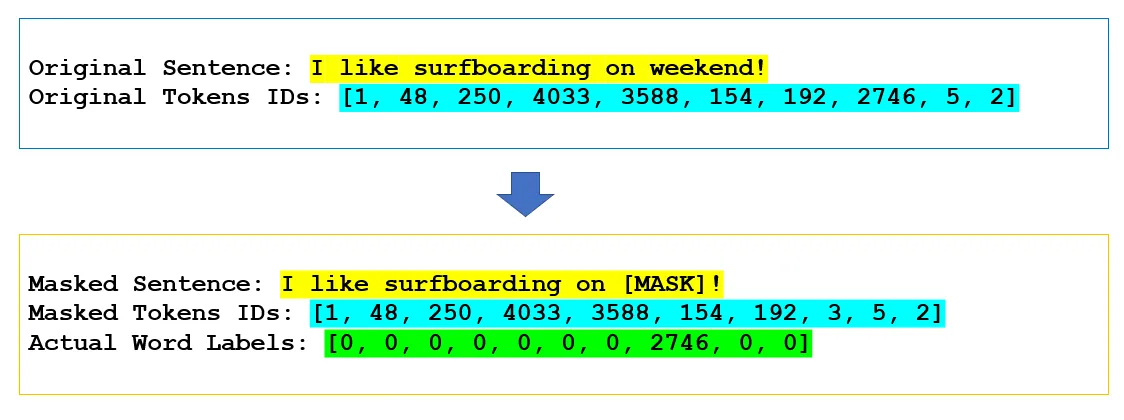

* **Step 3**:
Add special [CLS] and [SEP] tokens to the start and end of each sentence.
* **Step 4**:
Combine first and second sentences as single output (but separated by SEPtoken) and then followed by padding with PAD token to the sentence pairs and labels to max length. At this step, a segment label is created by assigning 1 for first sentence and 2 for second, whereas 0 for padded tokens.


By printing a sample output from the prepared dataset, we will see 4 keys output

* bert_input for tokenized sentences
* bert_label stores original words of selected masking tokens
* segment_label as the identifier for sentence A or B, this allows the model to distinguish between sentences
* is_next as truth label for whether the two sentences are related

In [10]:
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print(train_data[random.randrange(len(train_data))])

{'bert_input': tensor([    1,    17,    17,    17,   480,   501,  6080,     3,     3,   213,
          153,  1905, 12273,    17,    17,    17,     2,    48,   274,   146,
          437,    17,    48,   217,     3,   680,   435,   153,   150, 10915,
         1043,    16,    16,   248,   173,    11,    58,   780,   581,   269,
            3,   294,     3,     3,    16,    16,    48,    11,   265,   183,
          308,     3,    16,    16,   459,    34,     2,     0,     0,     0,
            0,     0,     0,     0]), 'bert_label': tensor([   0,    0,    0,    0,    0,    0,    0, 3428,   15,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  146,    0,    0,    0,    0,
         153,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  194,    0, 5173, 5817,    0,    0,    0,    0,
           0,    0,    0,  372,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'segment_label': tensor([1, 1, 

**Embedding**

The embedding in BERT comprises of three parts, mainly the token embeddings, segment embeddings and position embeddings.

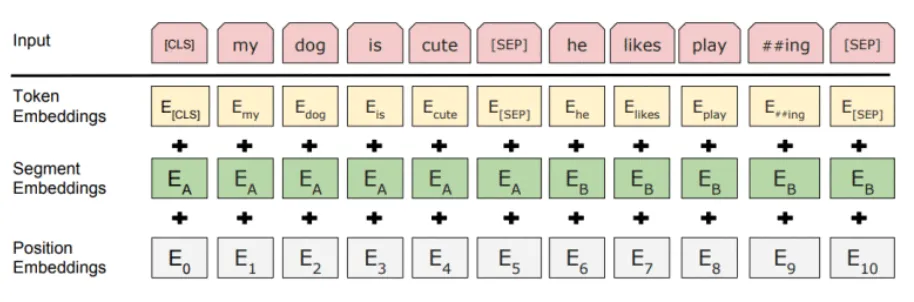


In NLP model, the order of the words and their position in a sentence matters and the meaning of the entire sentence can change if the words are re-ordered. As such, transformer model did a position embedding for each token in the input using the formula

In NLP model, the order of the words and their position in a sentence matters and the meaning of the entire sentence can change if the words are re-ordered. As such, transformer model did a position embedding for each token in the input using the formula


where
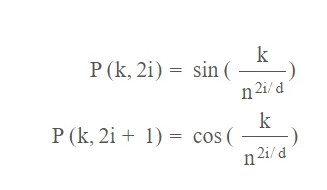

* k: Position of an object in input sequence, 0 < k < L/2
* d: Dimension of the output embedding space
* n: User defined scalar. Default by 10,000
* i: Used for mapping to column indices 0 < i < d/2. A single value of i maps to both sine and cosine functions

For all three different type of embeddings, they must be in the similar output size (768 in this case), so that all three of them can be summed together to be a single embedded output. You may notice thepadding_idx is specified as 0, this is to make pad token remains as 0 and not being updated during training.

In [11]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):   
            # for each dimension of the each position
            for i in range(0, d_model, 2):   
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)   
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)
       
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

**BERT Architecture**

The article has now reached the most exciting part where we will start implement the different layers for BERT model. Since BERT relies on a Transformer mechanism, it contains the attention module that learns contextual relationships between words in a text. This post explain the transformer architecture very well, and I recommend you to go through it to get a better picture on how it works.

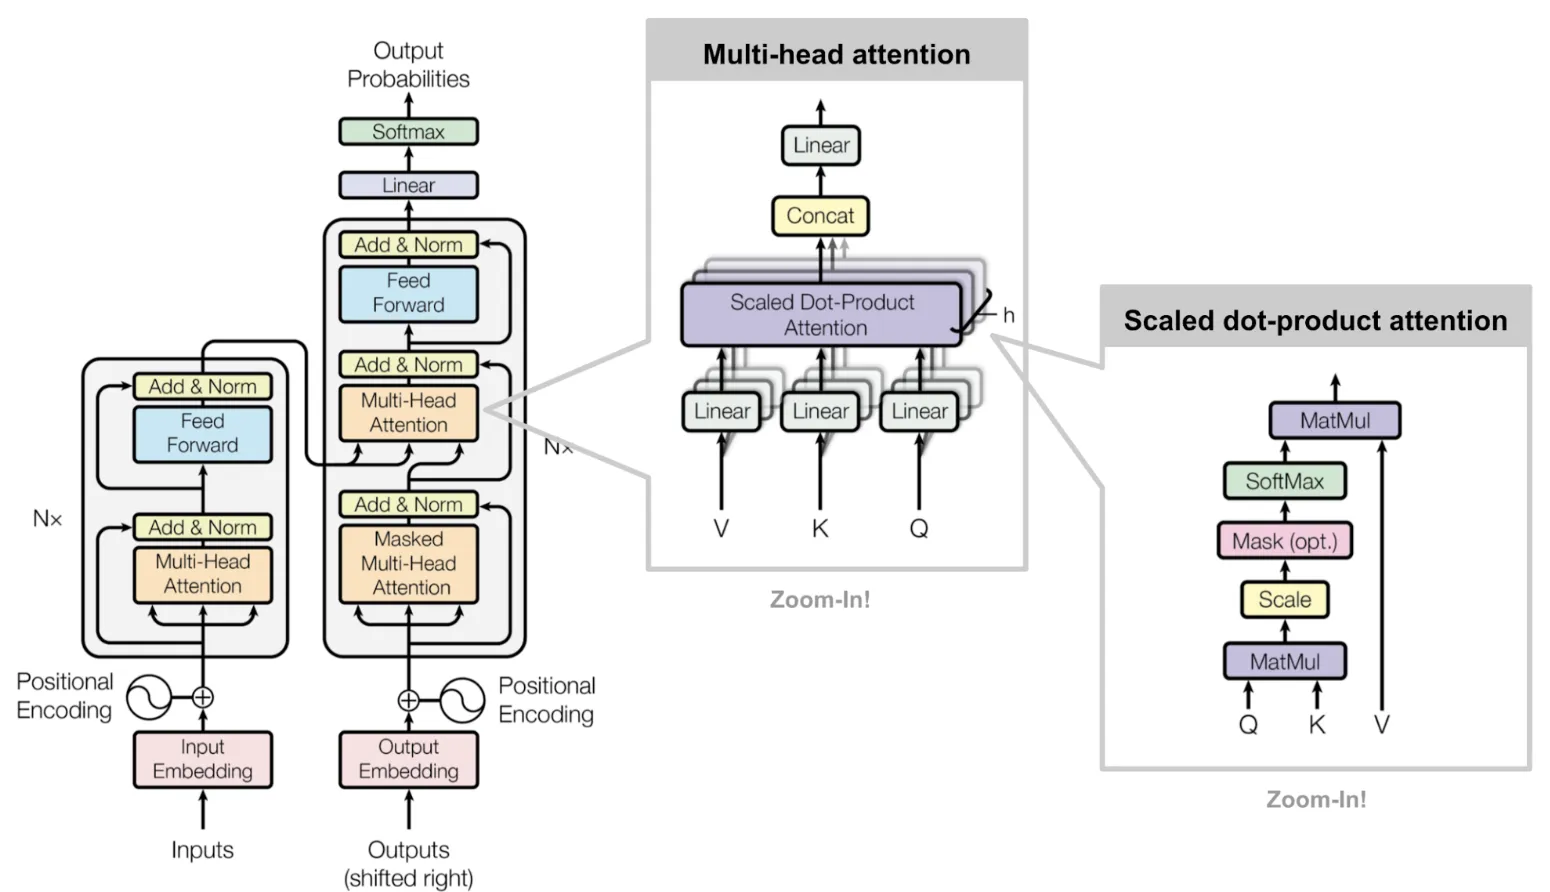

**Multi Head Attention**

A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The code snippet for Multi-head attention might looks complicated at first sight, but it is just a simple translation from the equation below

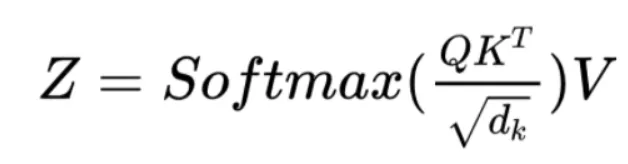

where Q, K, V are identical and linear transformation of input embeddings. The one thing that need more attention is the shape of input tensor, therefore, .permute() function is applied to amend the shape of tensor to fulfil the requirement for dot product.



In [13]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):
    
    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)    

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)           
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        
        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self, 
        d_model=768,
        heads=12, 
        feed_forward_hidden=768 * 4, 
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

**The details of the class MultiHeadedAttention**

* It’s called multi-head attention because the hidden size: d_model(768) is split by heads(12), this allows the model to jointly attend to information at different positions from different representational spaces.

* It takes the query, key, and value as inputs, and the size is permuted from (batch_size, max_len, hidden_size) → (batch_size, num_heads, max_len, hidden_size / num_heads ). This indicates that all the 3 inpurs are linearly projected from the d_model dimensional space to heads sets of d_k dimensional vectors.

* Attention score matrix is computed using matrix multiplication between the query(Q) and key(K) tensors, followed by scaling by the square root of the key tensor’s dimension

* The mask is applied to the attention matrix and filled with -1e9 (close to negative infinity). This is done because the large negative inputs to softmax are near zero in the output.

* The final output is a weighted sum of the value(V) tensors, where the weights are determined by the softmax of the scaled dot-product between the query and key vectors.

The EncoderLayer class contains 2 sublayers:.

* MultiHeadedAttention: A multi-headed self-attention module that computes the attention weights between each element in the input sequence
* FeedForward: A feedforward network with one hidden layer that applies a non-linear activation function (GELU) to the output of the first linear layer and produces a d_model dimensional output.

Each of these sublayers has a residual connection around it followed by a layer normalization LayerNorm(x + Sublayer(x)). Residual connections help in avoiding the vanishing gradient problem in deep networks.

**Final BERT Model**

Coming next, we are going to incorporate the encoder layer with attention mechanism into the final BERT’s construction.

In [15]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

The BERT class initializes the embedding layer for the input sequence, as well as multi layers of EncoderLayer blocks. The forward method of this class takes in the input sequence and a segment info tensor, applies attention masking to the input(for padded token), embeds the input sequence, and then passes it through the encoder blocks to obtain the output.

* **The NextSentencePrediction class** is a 2-class classification model that takes in the output of the BERT class and predicts whether the input sequence contains two consecutive sentences or not. The forward method applies applies linear transformation and log softmax function to obtain the predicted probabilities of the two classes.
* **The MaskedLanguageModel class** is a multi-class classification model that takes in the output of the BERT class and predicts the original tokens for the masked input sequence. The forward method applies a linear transformation and log softmax function to obtain the predicted probabilities of each token in the vocabulary.
* The BERTLM class combines the BERT, NextSentencePrediction, and MaskedLanguageModel classes to create a complete BERT language model.

**Optimizer**
The original BERT model was trained using Adam optimizer with a custom learning rate scheduler according to the formula in the paper https://arxiv.org/abs/1706.03762.

In [16]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

**Trainer**

We came a long way to finally combine what we have discussed above and start training a new BERT model.

In [17]:
class BERTTrainer:
    def __init__(
        self, 
        model, 
        train_dataloader, 
        test_dataloader=None, 
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        
        avg_loss = 0.0
        total_correct = 0
        total_element = 0
        
        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        ) 

The **BERTTrainerclass** contains train() and test() methods that call the iteration() method to iterate over the given dataloader (train or test) for a specified epoch. The iteration() method calculates the loss and accuracy of the model on the given data and updates the parameters using backpropagation and optimization. It also logs the progress of training with a progress bar and prints the average loss and accuracy at the end of each epoch. Finally, we can do a test run for the BERT model on the processed data with low number of epochs count.

In [ ]:
'''test run'''

train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 20

for epoch in range(epochs):
  bert_trainer.train(epoch)